In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate

from ramandecompy import dataprep

In [2]:
# dataprep.new_hdf5('ML_calibration')
# dataprep.add_calibration('ML_calibration.hdf5', '../ramandecompy/tests/test_files/water.xlsx', 'water')
# dataprep.add_calibration('ML_calibration.hdf5', '../ramandecompy/tests/test_files/Hydrogen_Baseline_Calibration.xlsx', 'hydrogen')
# dataprep.add_calibration('ML_calibration.hdf5', '../ramandecompy/tests/test_files/CarbonMonoxide_Baseline_Calibration.xlsx', 'carbon monoxide')
# dataprep.add_calibration('ML_calibration.hdf5', '../ramandecompy/tests/test_files/CO2_100wt%.csv', 'carbon dioxide')
# dataprep.add_calibration('ML_calibration.hdf5', '../ramandecompy/tests/test_files/FormicAcid_3_6percent.xlsx', 'formic acid')
# dataprep.add_calibration('ML_calibration.hdf5', '../ramandecompy/tests/test_files/sapphire.xlsx', 'sapphire')

In [3]:
dataprep.view_hdf5('ML_calibration.hdf5')

**** ML_calibration.hdf5 ****
carbon dioxide
|    Peak_01
|    Peak_02
|    counts
|    residuals
|    wavenumber
carbon monoxide
|    Peak_01
|    counts
|    residuals
|    wavenumber
formic acid
|    Peak_01
|    Peak_02
|    Peak_03
|    Peak_04
|    Peak_05
|    Peak_06
|    counts
|    residuals
|    wavenumber
hydrogen
|    Peak_01
|    Peak_02
|    Peak_03
|    Peak_04
|    counts
|    residuals
|    wavenumber
sapphire
|    Peak_01
|    Peak_02
|    Peak_03
|    Peak_04
|    counts
|    residuals
|    wavenumber
water
|    Peak_01
|    Peak_02
|    counts
|    residuals
|    wavenumber


### Now to write a function that will interpolate all the spectra in the hdf5_file, and sum them in a random distribution

In [9]:
def generate_spectra_dataset(hdf5_filename, target_compound, spectra_count):
    """
    docstring
    """
    hdf5 = h5py.File(hdf5_filename, 'r')
    # get list of compounds from hdf5 file
    compound_list = list(hdf5.keys())
    # create list of interpolated spectra
    interp_list = []
    for compound in compound_list:
        # interpolate
        tuple_list = interp_and_norm(hdf5_filename, compound)
        interp_list.append(tuple_list)
    # identify index of target_compound
    target_index = [i for i, compound in enumerate(compound_list) if target_compound in compound][0]
    # create list of spectra
    x_data = []
    y_data = []
    label = []
    for j in range(spectra_count): 
        # apply scaling to interpolated list
        for i, tuple_list in enumerate(interp_list):
            if i == 0:
                # apply scaling
                scaled_tuple_list = apply_scaling(tuple_list, j, i, target_index)
                summed_tuples = scaled_tuple_list
            else:
                # apply scaling
                scaled_tuple_list = apply_scaling(tuple_list, j, i, target_index)    
                summed_tuples = summed_tuples + scaled_tuple_list
        # sort by wavenumber
        combined = sorted(summed_tuples)
        # add by like
        same_x = {x:0 for x, _ in combined}
        for name, num in combined:
            same_x[name] += num
        sum_combined = list(map(tuple, same_x.items()))
        # unzip
        x_combined, y_combined = zip(*sum_combined)
        # set as arrays
        x_combined = np.asarray(x_combined)
        y_combined = np.asarray(y_combined)
        # plots the spectra, will remove from final rev
        plt.plot(x_combined, y_combined)
        # export data with label (0 = no target, 1 = yes target)
        x_data.append(x_combined)
        y_data.append(y_combined)
        label.append(j % 2)
    hdf5.close()
    return x_data, y_data, label

### now a function that will generate a random number between 0 and 1 and apply that to the counts data

In [5]:
def interp_and_norm(hdf5_filename, compound):
    """
    This function interpolates and normalizes wavenumber and counts data for the specified
    compound in an hdf5 calibration file.
    
    Args:
        hdf5_filename (str): The name and location of the relevant hdf5 calibration datafile.
        compound (str): The compound key in the hdf5 calibration datafile.

    Returns:
        tuple_list (list): A list of tuples containing pairs of wavenumber and counts values
                           for the interpolated and normalized compound spectra.
    """
    # handling input errors
    if not isinstance(hdf5_filename, str):
        raise TypeError('Passed value of `hdf5_filename` is not a string! Instead, it is: '
                        + str(type(hdf5_filename)))
    if not hdf5_filename.split('/')[-1].split('.')[-1] == 'hdf5':
        raise TypeError('`hdf5_filename` is not type = .hdf5! Instead, it is: '
                        + hdf5_filename.split('/')[-1].split('.')[-1])
    if not isinstance(compound, str):
        raise TypeError('Passed value of `hdf5_filename` is not a string! Instead, it is: '
                        + str(type(compound)))
    # open hdf5_file
    hdf5 = h5py.File(hdf5_filename, 'r')
    # interpolate spectra
    x_data = np.asarray(hdf5['{}/wavenumber'.format(compound)])
    y_data = np.asarray(hdf5['{}/counts'.format(compound)])
    interp_spectra = interpolate.interp1d(x_data, y_data, kind='cubic')
    # get integer values across x_range, protecting against edge cases
    x_range = np.arange(int(min(x_data)+1), int(max(x_data)))
    y_interp = interp_spectra(x_range)
    # normalize y_interp values
    y_interp_norm = y_interp/max(y_interp)
    # zip x and y values into tuples
    tuple_list = list(zip(x_range, y_interp_norm))
    # close hdf5 file
    hdf5.close()
    return tuple_list

def apply_scaling(tuple_list, j, i ,target_index):
    """
    docstring
    """
    # unpack tuple_list
    x_data, y_data = zip(*tuple_list)
    y_data = np.asarray(y_data)
    # alternate including target_compound or not
    # if j is odd include target_compound
    if j % 2 == 1:
        if i == target_index:
            y_data_scaled = y_data*np.random.uniform(0.01, 1)
        else:
            y_data_scaled = y_data*np.random.uniform()
    # if j is even no target_compound
    elif j % 2 == 0:
        if i == target_index:
            y_data_scaled = y_data*0
        else:
            y_data_scaled = y_data*np.random.uniform() 
    else:
        pass
    # repack tuple_list
    scaled_tuple_list = list(zip(x_data, y_data_scaled))
    return scaled_tuple_list

In [6]:
HDF5_FILENAME = '../ramandecompy/tests/test_files/test_calibration.hdf5'
TARGET_COMPOUND = 'water'
HDF5 = h5py.File(HDF5_FILENAME, 'r')
X_DATA = np.asarray(HDF5['water/wavenumber'])
Y_DATA = np.asarray(HDF5['water/counts'])
TUPLE_LIST = zip(X_DATA, Y_DATA)


def test_interp_and_norm():
    """
    docstring
    """
    tuple_list = interp_and_norm(HDF5_FILENAME, TARGET_COMPOUND)
    assert isinstance(tuple_list, list), '`tuple_list is not a list'
    assert isinstance(tuple_list[0], tuple), 'first element of `tuple_list` is not a tuple'
    assert isinstance(tuple_list[0][0], np.int64), 'first element of tuple is not a np.int64'
    x_data, y_data = zip(*tuple_list)
    assert max(y_data) <= 1, 'spectra was not normalized correctly'

test_interp_and_norm()
    
def test_apply_scaling():
    """
    docstring
    """
#     j =
#     i =
#     target_index = 
    scaled_tuple_list = apply_scaling(TUPLE_LIST, j, i, target_index)
    assert len(scaled_tuple_list) == len(TUPLE_LIST), 'scaled data not the same size as input data'
    assert isinstance(scaled_tuple_list, list), '`scaled_tuple_list` is not a list'
    assert isinstance(scaled_tuple_list[0], tuple), 'first element of `scaled_tuple_list` is not a tuple'


NameError: name 'h5py' is not defined

In [7]:
test_interp_and_norm()
# test_apply_scaling()

### Now implement some sort of machine learning, lets start with a logistic regression

10000

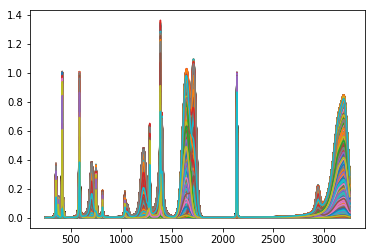

In [10]:
# first a function that will return a normalized interpolated spectra
target_compound = 'formic acid'
# compound = 'water'
hdf5_filename = 'ML_calibration.hdf5'
spectra_count = 10000

x_data, y_data, label = generate_spectra_dataset(hdf5_filename, target_compound, spectra_count)
len(x_data)

In [11]:
from sklearn.model_selection import train_test_split

# divide and extract test/train and validation data

X_train, X_test, y_train, y_test = train_test_split(y_data, label, test_size=0.2)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

8000 8000
2000 2000


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train, y_train)

# get predictions
Z = logreg.predict(X_test)

logreg.score(X_test, y_test)

1.0

In [13]:
hdf5 = h5py.File('spectrafit_dev3.hdf5', 'r')
x_spectra = np.asarray(hdf5['300C/25s/wavenumber'])
y_spectra = np.asarray(hdf5['300C/25s/counts'])
# normalize spectra
y_spectra = y_spectra/max(y_spectra)

In [14]:
x = x_data[0]
y_color = logreg.coef_
y = logreg.coef_.reshape(-1,1)

(0, 1)

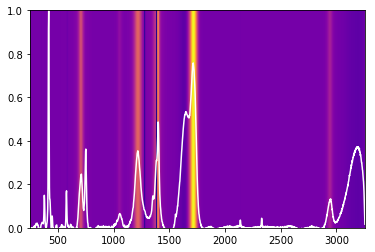

In [15]:
fig, ax = plt.subplots(nrows=1, sharex=True)
extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
ax.imshow(y_color, cmap="plasma", aspect="auto", extent=extent)
ax.plot(x_spectra, y_spectra, color='white')
ax.set_xlim(min(x), max(x))
ax.set_ylim(0, 1)

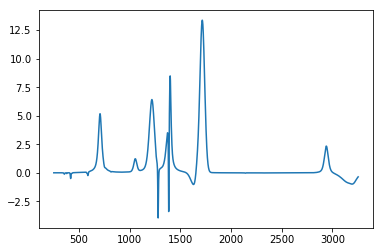

In [16]:
plt.plot(x, y)

## Support Vector Machines

In [17]:
from sklearn import svm

clf = svm.SVC(gamma='scale', kernel='linear')
clf.fit(X_train, y_train)

Z = clf.predict(X_test)

clf.score(X_test, y_test)

0.9985

In [18]:
x_clf = x_data[0]
y_color_clf = clf.coef_
y_clf = clf.coef_.reshape(-1,1)

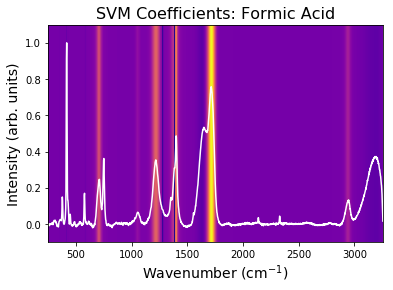

In [82]:
fig, ax = plt.subplots(nrows=1, sharex=True)
extent = [x_clf[0]-(x_clf[1]-x_clf[0])/2., x_clf[-1]+(x_clf[1]-x_clf[0])/2.,-0.1,1.1]
ax.imshow(y_color_clf, cmap="plasma", aspect="auto", extent=extent)
ax.plot(x_spectra, y_spectra, color='white')
ax.set_xlim(min(x_clf), max(x_clf))
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Intensity (arb. units)', fontsize=14)
ax.set_xlabel('Wavenumber (cm$^{-1}$)', fontsize=14)
ax.set_title('SVM Coefficients: Formic Acid', fontsize=16)
plt.savefig('SVM_FormicAcid', dpi=300)

### 1 water

10000

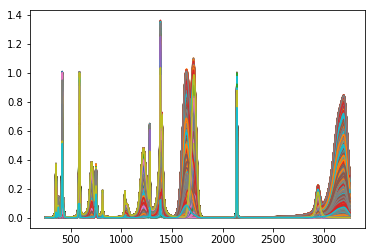

In [30]:
# first a function that will return a normalized interpolated spectra
target_compound = 'water'
# compound = 'water'
hdf5_filename = 'ML_calibration.hdf5'
spectra_count = 10000

x_data_1, y_data_1, label_1 = generate_spectra_dataset(hdf5_filename, target_compound, spectra_count)
len(x_data_1)

In [ ]:
# divide and extract test/train and validation data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(y_data_1, label_1, test_size=0.2)
print(len(X_train_1), len(y_train_1))
print(len(X_test_1), len(y_test_1))

# train model
clf_1 = svm.SVC(gamma='scale', kernel='linear')
clf_1.fit(X_train_1, y_train_1)

Z = clf_1.predict(X_test_1)

print('accuracy = {}'.format(clf_1.score(X_test_1, y_test_1)))

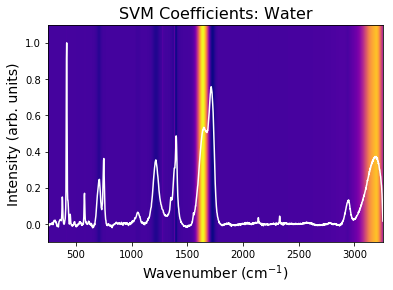

In [83]:
# prep plot data
x_clf_1 = x_data_1[0]
y_color_clf_1 = clf_1.coef_
y_clf_1 = clf_1.coef_.reshape(-1,1)

# generate plot
fig, ax = plt.subplots(nrows=1, sharex=True)
extent = [x_clf_1[0]-(x_clf_1[1]-x_clf_1[0])/2., x_clf_1[-1]+(x_clf_1[1]-x_clf_1[0])/2.,-0.1,1.1]
ax.imshow(y_color_clf_1, cmap="plasma", aspect="auto", extent=extent)
ax.plot(x_spectra, y_spectra, color='white')
ax.set_xlim(min(x_clf_1), max(x_clf_1))
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Intensity (arb. units)', fontsize=14)
ax.set_xlabel('Wavenumber (cm$^{-1}$)', fontsize=14)
ax.set_title('SVM Coefficients: Water', fontsize=16)
plt.savefig('SVM_Water', dpi=300)

## 2 carbon dioxide

10000

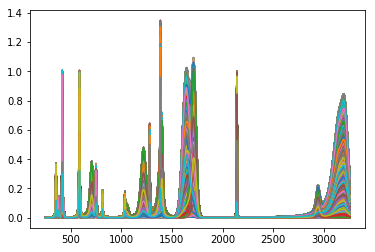

In [55]:
# first a function that will return a normalized interpolated spectra
target_compound = 'carbon dioxide'
# compound = 'water'
hdf5_filename = 'ML_calibration.hdf5'
spectra_count = 10000

x_data_2, y_data_2, label_2 = generate_spectra_dataset(hdf5_filename, target_compound, spectra_count)
len(x_data_2)

In [56]:
# divide and extract test/train and validation data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(y_data_2, label_2, test_size=0.2)
print(len(X_train_2), len(y_train_2))
print(len(X_test_2), len(y_test_2))

# train model
clf_2 = svm.SVC(gamma='scale', kernel='linear')
clf_2.fit(X_train_2, y_train_2)

Z = clf_2.predict(X_test_2)

print('accuracy = {}'.format(clf_2.score(X_test_2, y_test_2)))

8000 8000
2000 2000
accuracy = 0.99


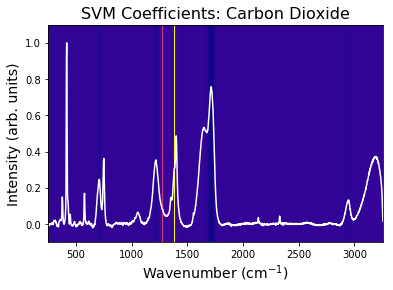

In [84]:
# prep plot data
x_clf_2 = x_data_2[0]
y_color_clf_2 = clf_2.coef_
y_clf_2 = clf_2.coef_.reshape(-1,1)

# generate plot
fig, ax = plt.subplots(nrows=1, sharex=True)
extent = [x_clf_2[0]-(x_clf_2[1]-x_clf_2[0])/2., x_clf_2[-1]+(x_clf_2[1]-x_clf_2[0])/2.,-0.1,1.1]
ax.imshow(y_color_clf_2, cmap="plasma", aspect="auto", extent=extent)
ax.plot(x_spectra, y_spectra, color='white')
ax.set_xlim(min(x_clf_2), max(x_clf_2))
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Intensity (arb. units)', fontsize=14)
ax.set_xlabel('Wavenumber (cm$^{-1}$)', fontsize=14)
ax.set_title('SVM Coefficients: Carbon Dioxide', fontsize=16)
plt.savefig('SVM_CarbonDioxide', dpi=300)

## 3 sapphire

10000

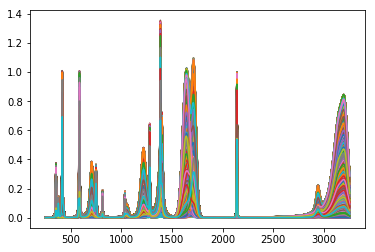

In [58]:
# first a function that will return a normalized interpolated spectra
target_compound = 'sapphire'
# compound = 'water'
hdf5_filename = 'ML_calibration.hdf5'
spectra_count = 10000

x_data_3, y_data_3, label_3 = generate_spectra_dataset(hdf5_filename, target_compound, spectra_count)
len(x_data_3)

In [59]:
# divide and extract test/train and validation data
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(y_data_3, label_3, test_size=0.2)
print(len(X_train_3), len(y_train_3))
print(len(X_test_3), len(y_test_3))

# train model
clf_3 = svm.SVC(gamma='scale', kernel='linear')
clf_3.fit(X_train_3, y_train_3)

Z = clf_3.predict(X_test_3)

print('accuracy = {}'.format(clf_3.score(X_test_3, y_test_3)))

8000 8000
2000 2000
accuracy = 0.989


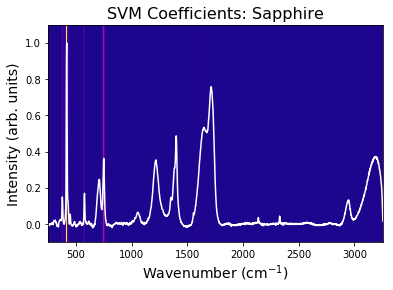

In [85]:
# prep plot data
x_clf_3 = x_data_3[0]
y_color_clf_3 = clf_3.coef_
y_clf_3 = clf_3.coef_.reshape(-1,1)

# generate plot
fig, ax = plt.subplots(nrows=1, sharex=True)
extent = [x_clf_3[0]-(x_clf_3[1]-x_clf_3[0])/2., x_clf_3[-1]+(x_clf_3[1]-x_clf_3[0])/2.,-0.1,1.1]
ax.imshow(y_color_clf_3, cmap="plasma", aspect="auto", extent=extent)
ax.plot(x_spectra, y_spectra, color='white')
ax.set_xlim(min(x_clf_3), max(x_clf_3))
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Intensity (arb. units)', fontsize=14)
ax.set_xlabel('Wavenumber (cm$^{-1}$)', fontsize=14)
ax.set_title('SVM Coefficients: Sapphire', fontsize=16)
plt.savefig('SCM_Sapphire', dpi=300)

## 4 carbon monoxide

10000

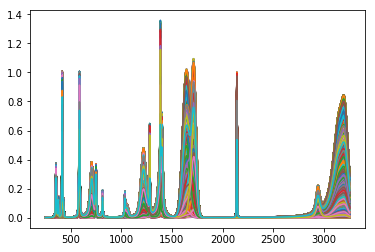

In [61]:
# first a function that will return a normalized interpolated spectra
target_compound = 'carbon monoxide'
# compound = 'water'
hdf5_filename = 'ML_calibration.hdf5'
spectra_count = 10000

x_data_4, y_data_4, label_4 = generate_spectra_dataset(hdf5_filename, target_compound, spectra_count)
len(x_data_4)

In [68]:
# divide and extract test/train and validation data
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(y_data_4, label_4, test_size=0.2)
print(len(X_train_4), len(y_train_4))
print(len(X_test_4), len(y_test_4))

# train model
clf_4 = svm.SVC(gamma='scale', kernel='linear')
clf_4.fit(X_train_4, y_train_4)

Z = clf_4.predict(X_test_4)

print('accuracy = {}'.format(clf_4.score(X_test_4, y_test_4)))

8000 8000
2000 2000
accuracy = 0.994


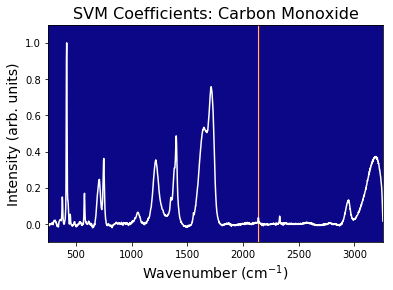

In [86]:
# prep plot data
x_clf_4 = x_data_4[0]
y_color_clf_4 = clf_4.coef_
y_clf_4 = clf_4.coef_.reshape(-1,1)

# generate plot
fig, ax = plt.subplots(nrows=1, sharex=True)
extent = [x_clf_4[0]-(x_clf_4[1]-x_clf_4[0])/2., x_clf_4[-1]+(x_clf_4[1]-x_clf_4[0])/2.,-0.1,1.1]
ax.imshow(y_color_clf_4, cmap="plasma", aspect="auto", extent=extent)
ax.plot(x_spectra, y_spectra, color='white')
ax.set_xlim(min(x_clf_4), max(x_clf_4))
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Intensity (arb. units)', fontsize=14)
ax.set_xlabel('Wavenumber (cm$^{-1}$)', fontsize=14)
ax.set_title('SVM Coefficients: Carbon Monoxide', fontsize=16)
plt.savefig('SVM_CarbonMonoxide', dpi=300)

## 5 hydrogen

10000

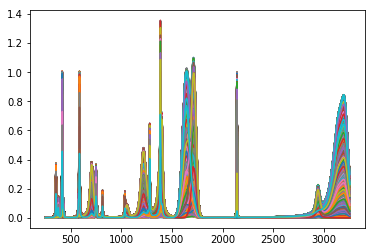

In [70]:
# first a function that will return a normalized interpolated spectra
target_compound = 'hydrogen'
# compound = 'water'
hdf5_filename = 'ML_calibration.hdf5'
spectra_count = 10000

x_data_5, y_data_5, label_5 = generate_spectra_dataset(hdf5_filename, target_compound, spectra_count)
len(x_data_5)

In [71]:
# divide and extract test/train and validation data
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(y_data_5, label_5, test_size=0.2)
print(len(X_train_5), len(y_train_5))
print(len(X_test_5), len(y_test_5))

# train model
clf_5 = svm.SVC(gamma='scale', kernel='linear')
clf_5.fit(X_train_5, y_train_5)

Z = clf_5.predict(X_test_5)

print('accuracy = {}'.format(clf_5.score(X_test_5, y_test_5)))

8000 8000
2000 2000
accuracy = 0.993


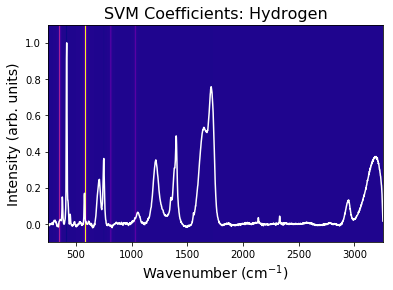

In [87]:
# prep plot data
x_clf_5 = x_data_5[0]
y_color_clf_5 = clf_5.coef_
y_clf_5 = clf_5.coef_.reshape(-1,1)

# generate plot
fig, ax = plt.subplots(nrows=1, sharex=True)
extent = [x_clf_5[0]-(x_clf_5[1]-x_clf_5[0])/2., x_clf_5[-1]+(x_clf_5[1]-x_clf_5[0])/2.,-0.1,1.1]
ax.imshow(y_color_clf_5, cmap="plasma", aspect="auto", extent=extent)
ax.plot(x_spectra, y_spectra, color='white')
ax.set_xlim(min(x_clf_5), max(x_clf_5))
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Intensity (arb. units)', fontsize=14)
ax.set_xlabel('Wavenumber (cm$^{-1}$)', fontsize=14)
ax.set_title('SVM Coefficients: Hydrogen', fontsize=16)
plt.savefig('SVM_Hydrogen', dpi=300)